The score on kaggle is 0.92437 top 32% (for comparison: my the 1st one in Spring was 1.42). For me that was a good experience, I tried to improve model but the improvements were insignificant. Visualisation is made by plotly. Here I have two models with tuned params (in the 1st one item count is clipped to range [0,22] and in the 2nd I tried (as many notebooks in kaggle) [0,20]), the difference of their results about 1% in favour of model 2.

## Load libraries and datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/project'

/content/drive/My Drive/project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

from itertools import product
from tqdm import tqdm
import gc

from sklearn.preprocessing import LabelEncoder

In [111]:
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test_df = pd.read_csv('test.csv')
sales_df = pd.read_csv('sales_train.csv')

## EDA

In [ ]:
item_cat.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [ ]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [ ]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [ ]:
sales_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [ ]:
test_df.head(3) # given shop_id and item_id have to predict monthly sales

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [ ]:
test_df.isna().sum() # all datasets have no missing values

ID         0
shop_id    0
item_id    0
dtype: int64

In [ ]:
items.shape, sales_df.shape, shops.shape, item_cat.shape, test_df.shape

((22170, 3), (2935849, 6), (60, 2), (84, 2), (214200, 3))

In [ ]:
set(item_cat.item_category_id.unique()) - set(items.item_category_id.unique()) # have the same item_category_ids, we can merge dfs

set()

In [62]:
items_df = items.merge(item_cat, on='item_category_id')

In [ ]:
len(set(test_df.item_id.unique()) - set(sales_df.item_id.unique())) # 363 unique items has test data but not train

363

In [ ]:
len(set(sales_df.item_id.unique()) - set(test_df.item_id.unique())) # 17070 unique items has train data but not test

17070

In [ ]:
len(set(test_df.shop_id.unique()) - set(sales_df.shop_id.unique())) # train data has all shop_id which are in test data

0

In [ ]:
len(set(sales_df.shop_id.unique()) - set(test_df.shop_id.unique())) # 18 unique shops has train data but not test

18

In [18]:
def make_barplot(df, x, top10=True):
  fig = plt.Figure(figsize=(15,10))
  if top10:
    fig = px.bar(data_frame=df, x=df[x].value_counts()[:10].index, y=df[x].value_counts()[:10], color=df[x].value_counts()[:10].index, height=700)
    fig.update_traces(hovertemplate='Category name: %{x}<br>Sales count: %{y}')
  else:
    fig = px.bar(data_frame=df, x=df[x].value_counts().index, y=df[x].value_counts(), color=df[x].value_counts().index,height=700)
  fig.update_layout(title=x, showlegend=False)
  return fig

In [ ]:
item_cat_names = pd.merge(sales_df, items_df, on='item_id', how='left')
make_barplot(item_cat_names, 'item_category_name')
# the main items are computer games, movie DVDs

In [ ]:
shop_names = pd.merge(sales_df, shops, on='shop_id', how='left')
make_barplot(shop_names, 'shop_name')
# most sales are comming from shops in Moscow

In [ ]:
del shop_names
del item_cat_names
gc.collect();

In [ ]:
make_barplot(sales_df, 'date_block_num', top10=False)
# mainly the largets sales are in December, which is obvious as in Russia it's time before New Year's holidays

In [6]:
def make_lineplot(df, x):
  fig = plt.Figure(figsize=(15,10))
  fig = px.line(x=df.index, y=df[x])
  fig.update_layout(title=x)
  return fig

In [ ]:
sales_gr = sales_df.groupby(['date_block_num']).agg({'item_cnt_day':'sum'})
sales_gr.columns = ['item_cnt_month']
fig = make_lineplot(sales_gr, 'item_cnt_month')
fig.update_traces(hovertemplate='Date_block: %{x}<br>Sales count: %{y}')
# again the largets sales are in December and there's a negative trend

In [8]:
sales_gr = sales_df.groupby(['date_block_num']).agg({'item_price':'sum'})
sales_gr.columns = ['item_price_month']
fig = make_lineplot(sales_gr, 'item_price_month')
fig.update_traces(hovertemplate='Date_block: %{x}<br>Sale\'s price sum: %{y}')
# but prices have positive trend, so in Russia prices are getting higher and thus amount of sales is getting lower

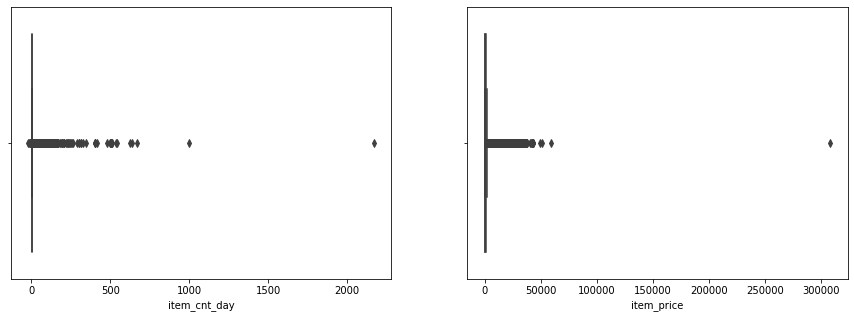

In [ ]:
# outliers + negative values
# on kaggle there's an assumtion that 'item_cnt_day' of -1 means returned goods
# and what concerns 'item_price', this is probably due to mistake in data
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x=sales_df.item_cnt_day)
plt.subplot(122)
sns.boxplot(x=sales_df.item_price)

## Cleaning and extracting features

In [112]:
# viewed on kaggle notebooks
# did this as these shop ids are the same, but have misspellings
sales_df.loc[sales_df['shop_id'] == 0, 'shop_id'] = 57
test_df.loc[test_df['shop_id'] == 0, 'shop_id'] = 57

sales_df.loc[sales_df['shop_id'] == 1, 'shop_id'] = 58
test_df.loc[test_df['shop_id'] == 1, 'shop_id'] = 58

sales_df.loc[sales_df['shop_id'] == 10, 'shop_id'] = 11
test_df.loc[test_df['shop_id'] == 10, 'shop_id'] = 11

In [113]:
# get rid of outliers
sales_df = sales_df[sales_df.item_cnt_day < 1001]
sales_df = sales_df[sales_df.item_price < 100000]

In [ ]:
# even for such big quantile our sales count is only 22 
sales_df.item_cnt_day.quantile(0.999)

22.0

In [ ]:
sales_df.shape, sales_df[sales_df.item_cnt_day > 22].shape # less than 1% of data

((2935847, 6), (2881, 6))

In [114]:
# clip 'item_cnt_day' in range [0, 22]
# sales_df['item_cnt_day'] = sales_df.item_cnt_day.clip(0,22)

In [66]:
# clip 'item_cnt_day' in range [0, 20] (as mainly kaggle notebooks have done)
# this strategy improved my predictions by ~ 1%
sales_df['item_cnt_day'] = sales_df.item_cnt_day.clip(0,20)

In [68]:
# impute with median price for the same shop & item 
sales_df[(sales_df.shop_id == 32)&(sales_df.item_id == 2973)].item_price.median()

2499.0

In [115]:
sales_df.loc[sales_df.item_price < 0, 'item_price'] = 2499.0

Encode text info like shop names and item categories. I also tried encoding item names, but there were many categories (about 1000) and this feature wasn't very important in model.

In [ ]:
shops.shop_name.unique() # can extract city

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [116]:
shops['city'] = shops.shop_name.str.split(' ').map(lambda x: x[0])

In [ ]:
shops.city.unique()
# change '!Якутск' to 'Якутск'

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [117]:
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [72]:
len(shops.city.unique()) # 31 categorical variable

31

In [118]:
# as you can remeber, in shop names most popular were from Moscow, here we have that most sales also comming from Moscow
temporary_df = pd.merge(sales_df, shops, on='shop_id')
temporary_df = temporary_df.groupby('city').agg({'item_cnt_day':'sum'})
temporary_df.reset_index(inplace=True)
fig = px.bar(temporary_df, x='city', y='item_cnt_day', color='city')
fig.update_traces(hovertemplate='City: %{x}<br>Sales amount: %{y}') 
fig.update_layout(title='Sales by city', showlegend=False)

In [119]:
del temporary_df

In [ ]:
items_df.item_category_name.unique()

array(['Кино - DVD', 'Программы - Для дома и офиса (Цифра)',
       'Музыка - CD локального производства', 'Игры - PS3',
       'Игры PC - Стандартные издания', 'Игры - XBOX 360',
       'Кино - Blu-Ray', 'Кино - Коллекционное', 'Музыка - MP3',
       'Книги - Аудиокниги', 'Программы - Обучающие (Цифра)',
       'Книги - Цифра', 'Книги - Методические материалы 1С',
       'Книги - Аудиокниги (Цифра)', 'Книги - Аудиокниги 1С',
       'Программы - Обучающие', 'Программы - 1С:Предприятие 8',
       'Игры PC - Цифра', 'Программы - Для дома и офиса',
       'Музыка - Винил', 'Музыка - CD фирменного производства',
       'Кино - Blu-Ray 3D', 'Подарки - Развитие',
       'Музыка - Музыкальное видео', 'Музыка - Подарочные издания',
       'Программы - MAC (Цифра)', 'Игры - PSP',
       'Игры PC - Дополнительные издания', 'Игры - PS4',
       'Игры - XBOX ONE', 'Игры PC - Коллекционные издания',
       'Подарки - Сувениры (в навеску)', 'Игры - PSVita',
       'Карты оплаты (Кино, Музыка, Игры)'

In [120]:
splits = items_df.item_category_name.str.split(' - ')
items_df['item_type'] = splits.map(lambda x: x[0])
items_df['item_subtype'] = splits.map(lambda x: x[1] if len(x)>1 else x[0])

In [ ]:
len(items_df.item_subtype.unique()) # 67 subtypes

67

In [ ]:
len(items_df.item_type.unique()) # 20 types

20

What concerns encoding, in Kaggle notebooks all use LabelEncoder for each of the following columns but I think that it would be inappropriate, as by this encoding method model can assume that categories which stand next to each other has smth in common, which is not true for 'city' and 'type' (in the case of 'subtype' feature 1st there are many categories - 67 and 2nd some of them share common meaning, i.g. 'Комиксы' which is followed by 'Позновательная литература', 'Художественная литература'. So I used for these features frequency encoding and for 'subtype' - LabelEncoder. Then making different models I've tried LabelEncoder for all features but my predictions were worse.

In [122]:
city_codes = shops.groupby('city').size() / shops.shape[0]
type_codes = items_df.groupby('item_type').size() / items_df.shape[0]

shops['city_code'] = shops.city.apply(lambda x: city_codes[x])
items_df['type_code'] = items_df.item_type.apply(lambda x: type_codes[x])
items_df['subtype_code'] = LabelEncoder().fit_transform(items_df.item_subtype)

Also in the next steps you'll see that I've changed types of data many times, this is due to pretty size of data which will be in the end and problems with Colab sessions when I trained model or tuned params and ran out of RAM.

In [123]:
shops['city_code'] = shops.city_code.astype(np.float16)
shops['shop_id'] = shops.shop_id.astype(np.int8)
items_df['type_code'] = items_df.type_code.astype(np.float16)
items_df['subtype_code'] = items_df.subtype_code.astype(np.int8)
items_df['item_category_id'] = items_df.item_category_id.astype(np.int8)

In [124]:
sales_df['revenue'] = sales_df.item_price * sales_df.item_cnt_day
sales_df['revenue'] = sales_df.revenue.astype(np.float32)
sales_df['date_block_num'] = sales_df.date_block_num.astype(np.int8)  
sales_df['item_cnt_day'] = sales_df.item_cnt_day.astype(np.int8)  
sales_df['shop_id'] = sales_df.shop_id.astype(np.int8)      

In [125]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935847 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int8   
 2   shop_id         int8   
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    int8   
 6   revenue         float32
dtypes: float32(1), float64(1), int64(1), int8(3), object(1)
memory usage: 109.2+ MB


In [ ]:
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,0.066650
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,0.066650
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0.016663
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0.016663
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,0.016663


In [ ]:
items_df.head()

,item_name,item_id,item_category_id,item_category_name,item_type,item_subtype,type_code,subtype_code
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD,0.336671,6
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD,0.336671,6
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD,0.336671,6
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD,0.336671,6
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD,0.336671,6


In [126]:
shops_id_code = shops[['shop_id','city_code']]
items_id_code = items_df[['item_id', 'item_category_id','type_code', 'subtype_code']]

In [127]:
# create df with different combinations of 'date_block_num','shop_id','item_id' (use product())
cols = ['date_block_num','shop_id','item_id']
matrix = []
for i in tqdm(range(34)):
    sales = sales_df[sales_df.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


In [128]:
matrix = np.vstack(matrix)
matrix.shape
# about 11 million of observations!

(10913804, 3)

In [129]:
sales_combin = pd.DataFrame(matrix, columns=cols)
sales_combin.head(3)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554


In [130]:
sales_combin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913804 entries, 0 to 10913803
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   date_block_num  int16
 1   shop_id         int16
 2   item_id         int16
dtypes: int16(3)
memory usage: 62.4 MB


In [131]:
# need to sort df 'sales_combin', as grouped df of 'sales_df' have index in sorted format
sales_combin.sort_values(cols,inplace=True)
group = sales_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

sales_combin = sales_combin.merge(group, on=cols, how='left')
sales_combin['item_cnt_month'] = sales_combin.item_cnt_month.fillna(0).astype('int16')

In [ ]:
# remember test data
test_df.head()

In [132]:
# this technique I also looked up in Kaggle, where we add our test data as next month (which in our case is 34) observations
test_df['date_block_num'] = 34
test_df.drop('ID', axis=1, inplace=True)
test_df = test_df.astype({'shop_id':'int8', 'item_id':'int16', 'date_block_num':'int8'})

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   shop_id         214200 non-null  int8 
 1   item_id         214200 non-null  int16
 2   date_block_num  214200 non-null  int8 
dtypes: int16(1), int8(2)
memory usage: 836.8 KB


In [133]:
# add test data to our main data
sales_combin = pd.concat([sales_combin, test_df], ignore_index=True, keys=cols)
sales_combin.item_cnt_month.fillna(0, inplace=True)
sales_combin.tail(3)

,date_block_num,shop_id,item_id,item_cnt_month
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


In [86]:
sales_combin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int16  
 1   shop_id         int16  
 2   item_id         int16  
 3   item_cnt_month  float64
dtypes: float64(1), int16(3)
memory usage: 148.6 MB


In [134]:
sales_combin['item_cnt_month'] = sales_combin.item_cnt_month.astype('int16')

In [135]:
# add shop and item dfs
sales_combin = pd.merge(sales_combin, shops_id_code, on='shop_id', how='left')
sales_combin = pd.merge(sales_combin, items_id_code, on='item_id', how='left')

In [136]:
sales_combin['date_block_num'] = sales_combin.date_block_num.astype('int8')
sales_combin['shop_id'] = sales_combin.shop_id.astype('int8')

In [ ]:
sales_combin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    int16  
 4   city_code         float16
 5   item_category_id  int8   
 6   type_code         float16
 7   subtype_code      int8   
dtypes: float16(2), int16(2), int8(4)
memory usage: 212.2 MB


In [137]:
sales_combin.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0,0.016663,40,0.336670,6
1,0,2,27,1,0.016663,19,0.080139,12
2,0,2,28,0,0.016663,30,0.097717,57
3,0,2,29,0,0.016663,23,0.080139,18
4,0,2,32,0,0.016663,40,0.336670,6


In [90]:
# func which adds specified number of lags
def add_lag(df, lags, col):
  tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
  for lag in lags:
    copy = tmp.copy()
    copy.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(lag)]
    copy['date_block_num'] += lag
    df = pd.merge(df, copy, on=['date_block_num', 'shop_id', 'item_id'], how='left')
  return df

In [138]:
# also I thought that 12's lag would be meaningfull, as we have the main sales in December
# but it turned out to not be a good predictor 
lags = [1,2,3,4,5,6]
sales_combin = add_lag(sales_combin, lags, 'item_cnt_month')

In [139]:
for lag in lags:
  sales_combin['item_cnt_month_lag_'+str(lag)] = sales_combin['item_cnt_month_lag_'+str(lag)].astype('float16')

In [ ]:
sales_combin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int8   
 1   shop_id               int8   
 2   item_id               int16  
 3   item_cnt_month        int16  
 4   city_code             float16
 5   item_category_id      int8   
 6   type_code             float16
 7   subtype_code          int8   
 8   item_cnt_month_lag_1  float16
 9   item_cnt_month_lag_2  float16
 10  item_cnt_month_lag_3  float16
 11  item_cnt_month_lag_4  float16
 12  item_cnt_month_lag_5  float16
 13  item_cnt_month_lag_6  float16
dtypes: float16(8), int16(2), int8(4)
memory usage: 339.6 MB


In [105]:
# check if works 
sales_combin[sales_combin.date_block_num == 0].head(5)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_6,date_shop_categ_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days,item_price_trend_lag_1,item_price_trend_lag_2,item_price_trend_lag_3,shop_revenue_trend_lag_1,shop_revenue_trend_lag_2,shop_revenue_trend_lag_3,shop_item_fist_sales,item_fist_sales
0,0,2,19,0,0.016663,40,0.336670,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0,2,27,1,0.016663,19,0.080139,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,0,2,28,0,0.016663,30,0.097717,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,0,2,29,0,0.016663,23,0.080139,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,0,2,32,0,0.016663,40,0.336670,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,31,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [106]:
# for observation date_block_num=1, shop_id=2, item_id=32 -> item_cnt_month_lag_1 == 0 (which is item_cnt_month for date_block 0)
sales_combin[(sales_combin.date_block_num == 1) & (sales_combin.item_id == 32)].head(1)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_6,date_shop_categ_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days,item_price_trend_lag_1,item_price_trend_lag_2,item_price_trend_lag_3,shop_revenue_trend_lag_1,shop_revenue_trend_lag_2,shop_revenue_trend_lag_3,shop_item_fist_sales,item_fist_sales
365180,1,2,32,0,0.016663,40,0.33667,6,0.0,NaN,NaN,NaN,NaN,NaN,0.36084,6.644531,NaN,NaN,0.141846,NaN,NaN,0.0,NaN,NaN,NaN,0.07312,0.337402,6.230469,0.073853,0.07312,0.2854,0.311279,1,28,0.354004,NaN,NaN,-0.383545,NaN,NaN,1,1


In [140]:
# add aggregated features from grouped dfs and agg-s funcs
# for each 'date_block_num', 'item_id', 'shop_id'
group = sales_combin.groupby('date_block_num').agg({'item_cnt_month':'mean'})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

# merge dfs
sales_combin = pd.merge(sales_combin, group, on='date_block_num', how='left')
sales_combin.date_avg_item_cnt = sales_combin.date_avg_item_cnt.astype('float16')
# add lag
sales_combin = add_lag(sales_combin, [1], 'date_avg_item_cnt')
sales_combin.date_avg_item_cnt_lag_1 = sales_combin.date_avg_item_cnt_lag_1.astype('float16')
# and drop the main column: this helped to decrease the size of data, prevent from dependence between lagged feature and primary feature 
# and keep only info about the previous sales for test block (as info such as aggregated mean about the current feature would be 0 in the case of test block) 
sales_combin.drop(['date_avg_item_cnt'], axis=1, inplace=True )

In [141]:
# group by date_block_num, item_id
group = sales_combin.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month':'mean'})
name = 'date_item_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'item_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
lags = [1,2,3]
sales_combin = add_lag(sales_combin, lags, name)
for lag in lags:
  sales_combin[name+'_lag_'+str(lag)] = sales_combin[name+'_lag_'+str(lag)].astype('float16')
sales_combin.drop(['date_item_avg_item_cnt'], axis=1, inplace=True )

In [142]:
# group by date_block_num, shop_id
group = sales_combin.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month':'mean'})
name = 'date_shop_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, lags, name)
for lag in lags:
  sales_combin[name+'_lag_'+str(lag)] = sales_combin[name+'_lag_'+str(lag)].astype('float16')
sales_combin.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [143]:
# group by date_block_num, shop_id, item_id
group = sales_combin.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month':'mean'})
name = 'date_shop_item_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
lags = [1,2,3,6]
sales_combin = add_lag(sales_combin, lags, name)
for lag in lags:
  sales_combin[name+'_lag_'+str(lag)] = sales_combin[name+'_lag_'+str(lag)].astype('float16')
sales_combin.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)

In [144]:
# group by date, shop, item_categ
group = sales_combin.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month':'mean'})
name = 'date_shop_categ_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, city_code
group = sales_combin.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month':'mean'})
name = 'date_city_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'city_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, item, city_code
group = sales_combin.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month':'mean'})
name = 'date_item_city_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, shop, type_code
group = sales_combin.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month':'mean'})
name = 'date_shop_type_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, shop, subtype_code
group = sales_combin.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month':'mean'})
name = 'date_shop_subtype_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, type_code
group = sales_combin.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month':'mean'})
name = 'date_type_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'type_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

# group by date, subtype_code
group = sales_combin.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month':'mean'})
name = 'date_subtype_avg_item_cnt'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'subtype_code'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')
sales_combin = add_lag(sales_combin, [1], name)
sales_combin[name+'_lag_1'] = sales_combin[name+'_lag_1'].astype('float16')
sales_combin.drop([name], axis=1, inplace=True)

In [145]:
# add time features like number of days and month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
sales_combin['month'] = (sales_combin.date_block_num % 12).astype('int8')
sales_combin['days'] = sales_combin.month.map(days).astype('int8')

In [ ]:
sales_combin.head(3)

In [146]:
# add features from train df like 'revenue', 'item_price'
# mean price for each item
group = sales_df.groupby(['item_id']).agg({'item_price': ['mean']})
name = 'item_avg_item_price'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['item_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')

# mean price for each pair of date_block and item
group = sales_df.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
name = 'date_item_avg_item_price'
group.columns = [name]
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'item_id'], how='left')
sales_combin[name] = sales_combin[name].astype('float16')

# and this I borrowed from kaggle
# here we calculate trend of the mean item price by date blocks
sales_combin['item_price_trend'] = (sales_combin.date_item_avg_item_price - sales_combin.item_avg_item_price) / sales_combin.item_avg_item_price
lags = [1, 2, 3]
sales_combin = add_lag(sales_combin, lags, 'item_price_trend')
for lag in lags:
  sales_combin['item_price_trend_lag_'+str(lag)] = sales_combin['item_price_trend_lag_'+str(lag)].astype('float16')
sales_combin.drop(['item_price_trend', 'date_item_avg_item_price', 'item_avg_item_price'], axis=1, inplace=True)

In [147]:
# group by date, shop
group = sales_df.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['mean']})
group.columns = ['date_shop_avg_revenue']
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['date_block_num', 'shop_id'], how='left')
sales_combin['date_shop_avg_revenue'] = sales_combin['date_shop_avg_revenue'].astype('float16')

group = group.groupby('shop_id').agg({'date_shop_avg_revenue':'mean'})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

sales_combin = pd.merge(sales_combin, group, on=['shop_id'], how='left')
sales_combin['shop_avg_revenue'] = sales_combin['shop_avg_revenue'].astype('float16')

# add revenue trend
sales_combin['shop_revenue_trend'] = (sales_combin.date_shop_avg_revenue - sales_combin.shop_avg_revenue) / sales_combin.shop_avg_revenue
sales_combin = add_lag(sales_combin, lags, 'shop_revenue_trend')
for lag in lags:
  sales_combin['shop_revenue_trend_lag_'+str(lag)] = sales_combin['shop_revenue_trend_lag_'+str(lag)].astype('float16')
sales_combin.drop(['shop_revenue_trend', 'date_shop_avg_revenue', 'shop_avg_revenue'], axis=1, inplace=True)

In [103]:
# for each shop-item pair and then for each item find fist date_block of sales
sales_combin.groupby(['shop_id', 'item_id'])['date_block_num'].min()

shop_id  item_id
2        0          20
         1          15
         2          19
         3          18
         4          20
                    ..
59       22165       7
         22166       9
         22167       8
         22168       0
         22169      14
Name: date_block_num, Length: 1128896, dtype: int8

In [148]:
# and calculate how many date_blocks has passed since the first sale's date_block
sales_combin['shop_item_fist_sales'] = sales_combin.date_block_num - sales_combin.groupby(['shop_id', 'item_id'])['date_block_num'].transform('min')
sales_combin['item_fist_sales'] = sales_combin.date_block_num - sales_combin.groupby(['item_id'])['date_block_num'].transform('min')

In [149]:
sales_combin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 42 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        int16  
 4   city_code                             float16
 5   item_category_id                      int8   
 6   type_code                             float16
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_4                  float16
 12  item_cnt_month_lag_5                  float16
 13  item_cnt_month_lag_6                  float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_item_avg

In [150]:
# as the biggest lag is 6, which means that we can omit first 5 date blocks
sales_combin = sales_combin[sales_combin.date_block_num > 5]

In [109]:
sales_combin.isna().sum()
# have lots of missing values in lagged features, but xgboost we'll cope with them

date_block_num                                0
shop_id                                       0
item_id                                       0
item_cnt_month                                0
city_code                                     0
item_category_id                              0
type_code                                     0
subtype_code                                  0
item_cnt_month_lag_1                    1812889
item_cnt_month_lag_2                    2082221
item_cnt_month_lag_3                    2351588
item_cnt_month_lag_4                    2611120
item_cnt_month_lag_5                    2874218
item_cnt_month_lag_6                    3123035
date_avg_item_cnt_lag_1                 1812889
date_item_avg_item_cnt_lag_1            1812889
date_item_avg_item_cnt_lag_2            2082221
date_item_avg_item_cnt_lag_3            2351588
date_shop_avg_item_cnt_lag_1            1812889
date_shop_avg_item_cnt_lag_2            2082221
date_shop_avg_item_cnt_lag_3            

In [151]:
sales_combin.to_pickle('sales_demo_20.pkl')

## Prepare train, val and test data

In [3]:
# load model
sales_combin = pd.read_pickle('sales_demo_20.pkl')
sales_combin.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_1,date_shop_item_avg_item_cnt_lag_2,date_shop_item_avg_item_cnt_lag_3,date_shop_item_avg_item_cnt_lag_6,date_shop_categ_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,month,days,item_price_trend_lag_1,item_price_trend_lag_2,item_price_trend_lag_3,shop_revenue_trend_lag_1,shop_revenue_trend_lag_2,shop_revenue_trend_lag_3,shop_item_fist_sales,item_fist_sales
2262708,6,2,27,0,0.016663,19,0.080139,12,0.0,0.0,0.0,0.0,0.0,1.0,0.316406,0.043488,0.044434,0.021744,0.098145,0.066345,0.071838,0.0,0.0,0.0,1.0,0.724609,0.262695,0.00000,0.563965,0.650391,0.796875,0.888184,6,31,-0.043121,0.196411,0.367676,-0.332764,-0.38208,-0.32959,6,6
2262709,6,2,28,0,0.016663,30,0.097717,57,0.0,0.0,0.0,0.0,0.0,0.0,0.316406,0.086975,0.111084,0.130493,0.098145,0.066345,0.071838,0.0,0.0,0.0,0.0,0.431641,0.262695,0.06665,0.288330,0.431641,0.787598,1.236328,6,31,-0.038696,0.283936,0.256348,-0.332764,-0.38208,-0.32959,6,6
2262710,6,2,29,0,0.016663,23,0.080139,18,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.022217,NaN,NaN,0.066345,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,31,NaN,-0.147827,NaN,NaN,-0.38208,NaN,6,6


In [4]:
X_train = sales_combin[sales_combin.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = sales_combin[sales_combin.date_block_num < 33]['item_cnt_month']

X_val = sales_combin[sales_combin.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = sales_combin[sales_combin.date_block_num == 33]['item_cnt_month']

X_test = sales_combin[sales_combin.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
del sales_combin
import gc
gc.collect();

## Model 1 (where item count in range 0-22)

In [8]:
model1 = XGBRegressor(max_depth=10,
                      eta=0.05,
                      n_estimators=1000,
                      gamma=1,
                      min_child_weight=5,
                      colsample_bytree=0.8, 
                      subsample=0.8, 
                      seed=42,
                      tree_method='gpu_hist', gpu_id=0)
model1.fit(X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True,
    early_stopping_rounds=50)

[14:27:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.61821	validation_1-rmse:2.21504
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.44765	validation_1-rmse:2.11411
[2]	validation_0-rmse:2.29772	validation_1-rmse:2.00065
[3]	validation_0-rmse:2.16712	validation_1-rmse:1.90367
[4]	validation_0-rmse:2.05219	validation_1-rmse:1.81961
[5]	validation_0-rmse:1.95042	validation_1-rmse:1.74453
[6]	validation_0-rmse:1.86169	validation_1-rmse:1.66876
[7]	validation_0-rmse:1.78552	validation_1-rmse:1.59904
[8]	validation_0-rmse:1.71759	validation_1-rmse:1.55134
[9]	validation_0-rmse:1.6598	validation_1-rmse:1.51199
[10]	validation_0-rmse:1.60833	validation_1-rmse:1.48918
[11]	validation_0-rmse:1.5638	validation_1-rmse:1.46471
[12]	validation_0-rmse:1.52414	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.05, gamma=1,
             gpu_id=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=5, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, tree_method='gpu_hist',
             verbosity=1)

In [ ]:
params = {
    'gamma':[0.5, 0.7, 1]
}
grid_cv = GridSearchCV(XGBRegressor(eta=0.05, n_estimators=150, max_depth=10, min_child_weight=5, gamma=0.4, subsample=0.8, colsample_bytree=0.8, tree_method='gpu_hist', gpu_id=0), 
                       params, scoring='neg_root_mean_squared_error', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'eta': 0.05, 'max_depth': 10}, -1.6123226881027222)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'min_child_weight': 5}, -1.6104209184646607)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'gamma': 1}, -1.613189148902893)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, -1.6765363454818725)

In [ ]:
y_test = model1.predict(X_test).clip(0, 22)

submission = pd.DataFrame({
    'ID': range(X_test.shape[0]), 
    'item_cnt_month': y_test
})

In [ ]:
submission.to_csv('xgb_submission.csv', index=False) # best score was 0.93289

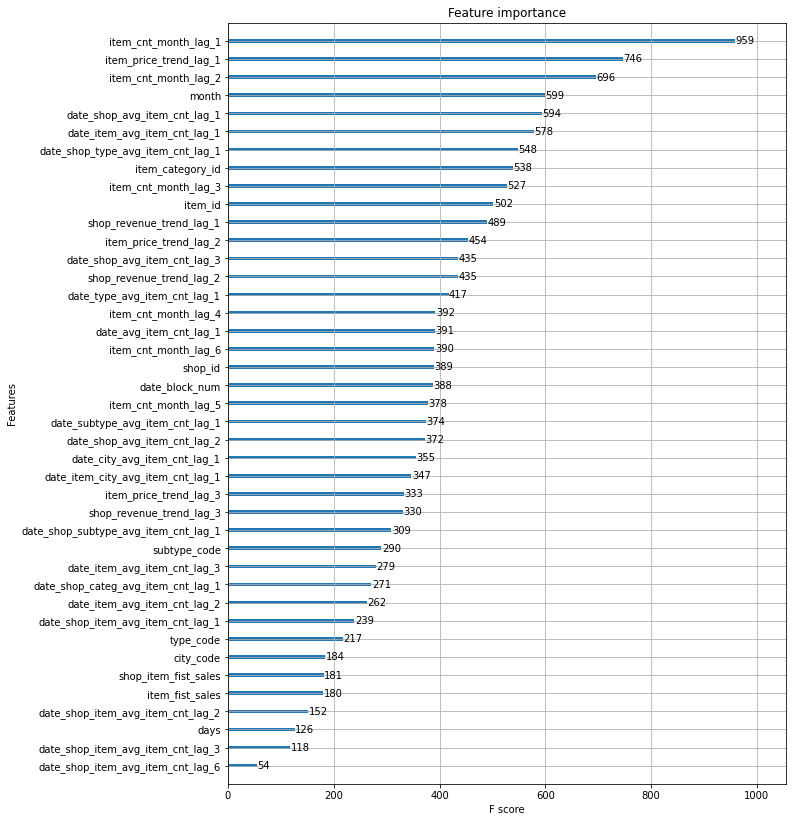

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
plot_importance(model1, ax=ax)
# should features with remove lag_12

## Model 2

In [6]:
model1 = XGBRegressor(max_depth=10,
                      eta=0.05,
                      n_estimators=1000,
                      gamma=0.4,
                      min_child_weight=3,
                      colsample_bytree=0.7, 
                      subsample=0.9, 
                      seed=42,
                      tree_method='gpu_hist', gpu_id=0)
model1.fit(X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True,
    early_stopping_rounds=50)

[14:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.55292	validation_1-rmse:2.15043
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.38572	validation_1-rmse:1.99511
[2]	validation_0-rmse:2.23924	validation_1-rmse:1.88748
[3]	validation_0-rmse:2.11178	validation_1-rmse:1.79215
[4]	validation_0-rmse:1.99935	validation_1-rmse:1.72128
[5]	validation_0-rmse:1.90069	validation_1-rmse:1.63755
[6]	validation_0-rmse:1.81422	validation_1-rmse:1.58053
[7]	validation_0-rmse:1.74054	validation_1-rmse:1.52173
[8]	validation_0-rmse:1.67204	validation_1-rmse:1.47987
[9]	validation_0-rmse:1.61314	validation_1-rmse:1.44756
[10]	validation_0-rmse:1.56193	validation_1-rmse:1.41671
[11]	validation_0-rmse:1.51904	validation_1-rmse:1.39102
[12]	validation_0-rmse:1.47927	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.05, gamma=0.4,
             gpu_id=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=3, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.9, tree_method='gpu_hist',
             verbosity=1)

In [6]:
params = {
    'subsample':[0.8, 0.9],
    'colsample_bytree':[0.7, 0.8],
    'eta': [0.05, 0.1], 'max_depth': [5, 10],
    'gamma': [0.7, 0.4], 'min_child_weight': [3, 5]
}
grid_cv = GridSearchCV(XGBRegressor(eta=0.05, n_estimators=150, max_depth=10, min_child_weight=3, gamma=0.7, subsample=0.8, colsample_bytree=0.8, tree_method='gpu_hist', gpu_id=0), 
                       params, scoring='neg_root_mean_squared_error', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:35:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed: 122.0min finished


[16:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, eta=0.05, gamma=0.7,
                                    gpu_id=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=10, min_child_weight=3,
                                    missing=None, n_estimators=150, n_jobs=1,
                                    nthread=None, objective='reg:linear',
                                    random_s...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.8, tree_method='gpu_hist',
                                    verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7, 0.8], 'eta': [0.05, 0.1],

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'eta': 0.05, 'max_depth': 10}, -1.5900901556015015)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'gamma': 0.7, 'min_child_weight': 3}, -1.5730415821075439)

In [ ]:
grid_cv.best_params_, grid_cv.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, -1.5559704542160033)

In [7]:
y_test = model1.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    'ID': range(X_test.shape[0]), 
    'item_cnt_month': y_test
})
submission.to_csv('xgb_submission3.csv', index=False) # score 0.92437